Problem 6 : Implementation
==========

In [44]:
import torch
import torch.nn as nn
import time
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader


# Make sure to use only 10% of the available MNIST data.
# Otherwise, experiment will take quite long (around 90 minutes).
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

learning_rate = 0.1
batch_size = 64
epochs = 150

def create_randomized_dataset(mnist_data, ratio):
    # Get data and target from MNIST dataset
    data = mnist_data.data
    target = mnist_data.targets
    # Calculate the length of 10% subset
    subset_length = len(mnist_data) // 10
    # Calculate the number of labels to randomize
    randomized_length = int(subset_length * ratio)
    # Randomize labels
    target[:randomized_length] = torch.from_numpy(np.random.choice(10, randomized_length))
    # Create subset of MNIST data
    subset = Subset(mnist_data, range(subset_length))
    return subset

# Evaluate the accuracy of the model on the test dataset
def test_model(model, test_loader):
    model.eval()
    mis = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            mis += (predicted != labels).sum().item()
    loss = mis/total*100
    return loss

# (Modified version of AlexNet)
class AlexNet(nn.Module):
    def __init__(self, num_class=10):
        super(AlexNet, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc_layer1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(6400, 800),
            nn.ReLU(inplace=True),
            nn.Linear(800, 10)
        )

    def forward(self, x):
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = torch.flatten(output, 1)
        output = self.fc_layer1(output)
        return output

# Load the MNIST dataset
train_data = datasets.MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())

# Define the ratios of randomized labels to experiment with
label_ratios = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

test_data = datasets.MNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

# Define a data loader for the test dataset
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
losses = []
times = []
test_losses = []
train_acc = []

for label_ratio in label_ratios:
    print(f"\nExperiment with {int(label_ratio * 100)}% randomized labels")
    tmp_losses = []

    # Create a dataset subset with the specified label ratio
    train_subset = create_randomized_dataset(train_data, label_ratio)

    # Define a data loader for the subset
    batch_size = 64
    train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)

    # Define the model, optimizer, and loss function
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = AlexNet().to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train the model
    tick = time.time()
    for epoch in range(epochs):
        tmp2_losses = []
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            tmp2_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        tmp_losses.append(np.mean(tmp2_losses))
        train_accuracy = correct / total * 100
        train_acc.append(train_accuracy)
    tock = time.time()
    test_loss = test_model(model, test_loader)

    # logging
    losses.append(tmp_losses)
    times.append(tock-tick)
    test_losses.append(test_loss)

    print(f"Total training time: {tock - tick}")
    print(f"Test Loss : {test_loss}")



Experiment with 0% randomized labels
Total training time: 168.75202250480652
Test Loss : 1.51

Experiment with 20% randomized labels
Total training time: 169.44170451164246
Test Loss : 8.89

Experiment with 40% randomized labels
Total training time: 167.86384105682373
Test Loss : 22.5

Experiment with 60% randomized labels
Total training time: 166.9189920425415
Test Loss : 47.699999999999996

Experiment with 80% randomized labels
Total training time: 167.54191875457764
Test Loss : 66.82000000000001

Experiment with 100% randomized labels
Total training time: 168.02080726623535
Test Loss : 91.36999999999999


Text(0, 0.5, 'Loss')

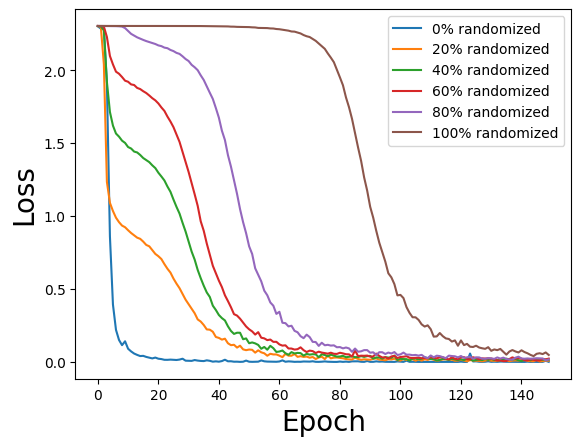

In [49]:
import matplotlib.pyplot as plt
plt.plot(range(150), losses[0],label = "0% randomized")
plt.plot(range(150), losses[1],label = "20% randomized")
plt.plot(range(150), losses[2],label = "40% randomized")
plt.plot(range(150), losses[3],label = "60% randomized")
plt.plot(range(150), losses[4],label = "80% randomized")
plt.plot(range(150), losses[5],label = "100% randomized")
plt.legend()
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Loss",fontsize = 20)


Text(0, 0.5, 'Train Accuracy')

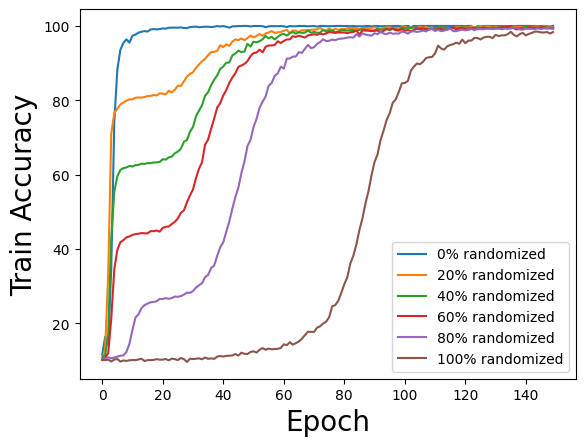

In [48]:
plt.plot(range(150), train_acc[:150],label = "0% randomized")
plt.plot(range(150), train_acc[150:300],label = "20% randomized")
plt.plot(range(150), train_acc[300:450],label = "40% randomized")
plt.plot(range(150), train_acc[450:600],label = "60% randomized")
plt.plot(range(150), train_acc[600:750],label = "80% randomized")
plt.plot(range(150), train_acc[750:900],label = "100% randomized")
plt.legend()
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Train Accuracy",fontsize = 20)


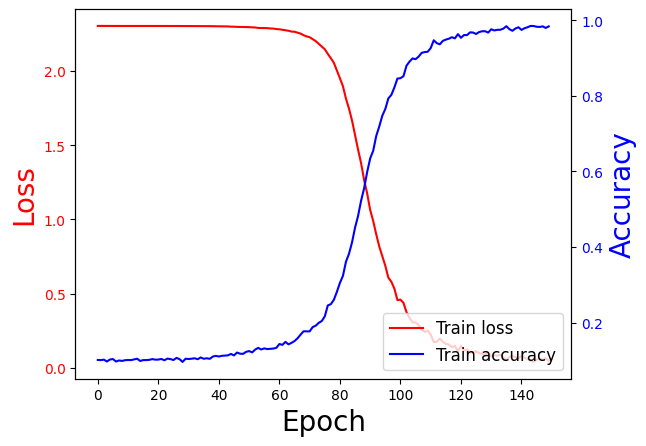

In [50]:
fig,ax1 = plt.subplots()
l1 = ax1.plot(range(150), losses[5],label = "Train loss",color = 'r')
ax1.tick_params(axis='y', labelcolor='r')
plt.ylabel("Loss",fontsize = 20, color = 'r')
ax2 = ax1.twinx()
l2 = ax2.plot(range(150), np.array(train_acc[750:900])/100,label = "Train accuracy",color = 'b')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel("Epoch",fontsize = 20)
plt.ylabel("Accuracy",fontsize = 20, color = 'b')
l = l1 + l2
labels = [x.get_label() for x in l]
ax1.legend(l, labels,  fontsize = 12, loc = 4)


(165.0, 170.0)

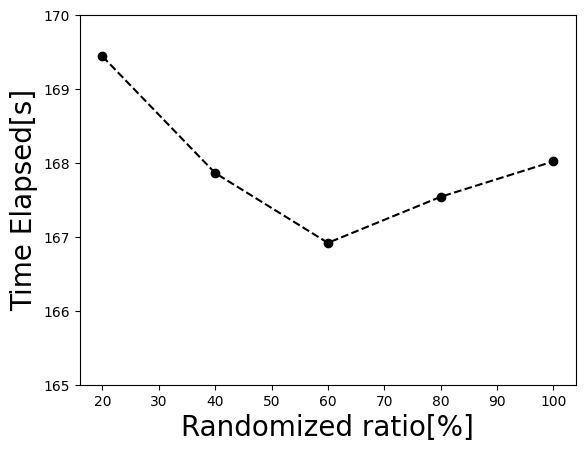

In [45]:
plt.plot(range(20,120,20), times[1:],ls = '--',color = 'k')
plt.scatter(range(20,120,20), times[1:],color = 'k')
plt.xlabel("Randomized ratio[%]",fontsize = 20)
plt.ylabel("Time Elapsed[s]",fontsize = 20)
plt.ylim([165,170])


Text(0, 0.5, 'Test Error[%]')

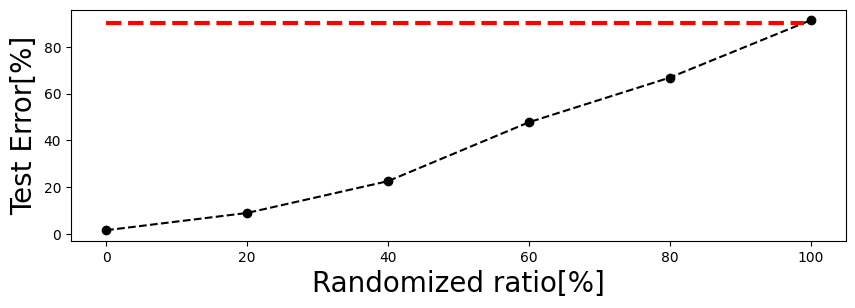

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,3))
plt.plot(range(0,120,20), np.array(test_losses),ls = '--',color = 'k')
plt.plot(range(100), 90*np.ones(100),ls = '--',color = 'r', lw = 3)
plt.scatter(range(0,120,20), np.array(test_losses),color = 'k')
plt.xlabel("Randomized ratio[%]",fontsize = 20)
plt.ylabel("Test Error[%]",fontsize = 20)
